In [6]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pathlib import Path
import numpy as np

BASE_DIR = Path.cwd().parent

features  =pd.read_csv(f'{BASE_DIR}/data/features_test.csv')

excluded_features = ['account_uuid', 'state', 'business_structure','industry', 'subindustry',  'index','account_value']
feature_columns = list(set(features.columns) - set(excluded_features))
X = features[feature_columns]
#y = features['account_value']

In [7]:
model = joblib.load(f'{BASE_DIR}/model/xgboost_model.joblib')

In [8]:
# Run this in your training script to see how many features you have
print(f"Number of features: {X.shape[1]}")
print(f"Feature names: {X.columns.tolist() if hasattr(X, 'columns') else 'No names'}")

Number of features: 39
Feature names: ['quotes_per_employee', 'avg_x_nproducts', 'max_premium', 'region', 'carrier_diversity', 'num_carriers', 'carrier_concentration', 'premium_per_quote', 'revenue_x_payroll', 'num_products_requested', 'avg_premium', 'industry_revenue_encoded', 'annual_revenue', 'premium_per_employee', 'state_revenue_encoded', 'iqr_premium', 'log_annual_revenue', 'num_employees', 'premium_range', 'num_quotes', 'premium_to_revenue_ratio', 'subindustry_sum_premium_encoded', 'min_premium', 'premium_ratio_max_avg', 'industry_sum_premium_encoded', 'total_quotes', 'total_payroll', 'product_concentration', 'quotes_per_million_revenue', 'year_established', 'max_x_nquotes', 'business_structure_revenue_encoded', 'business_structure_premium_sum_encoded', 'state_premium_sum_encoded', 'revenue_per_employee', 'subindustry_revenue_encoded', 'log_total_payroll', 'sum_premium', 'premium_per_revenue']


In [9]:
expected_features = model.feature_names_in_ 

In [10]:
expected_features = model.feature_names_in_  # o model.get_booster().feature_names

# Reordenar X para que coincida exactamente
X_ordered = X[expected_features]

# Ahora predecir
y_pred = model.predict(X_ordered)


In [11]:
features['account_value'] = y_pred

In [12]:
features[['account_uuid','account_value']].to_csv(f'{BASE_DIR}/data/predictions_old.csv', index=False)

In [103]:
expected_features = model.feature_names_in_  # o model.get_booster().feature_names

# Reordenar X para que coincida exactamente
X_ordered = X[expected_features]

# Ahora predecir
y_pred = model.predict(X_ordered)


features['y_pred'] = y_pred


features['diff'] = np.abs(features['y_pred'] - features['account_value'])
features['diff_perc'] = np.abs(features['y_pred'] - features['account_value'])/features['account_value'] * 100

features[['account_value','y_pred','diff','diff_perc']].sort_values(by='diff', ascending=False).head(10)

,account_value,y_pred,diff,diff_perc
5521,29806.50,13207.910156,16598.589844,55.687819
1103,46333.00,33388.816406,12944.183594,27.937288
4234,25392.00,13953.586914,11438.413086,45.047311
4517,36115.54,25699.933594,10415.606406,28.839681
1853,19712.21,9981.816406,9730.393594,49.362266
2427,24266.41,15373.849609,8892.560391,36.645554
904,21694.00,13010.527344,8683.472656,40.027070
943,45745.00,37214.917969,8530.082031,18.647026
2403,17853.00,9819.494141,8033.505859,44.998072
4434,13440.45,6255.047852,7185.402148,53.461024


In [53]:
len(features[features['diff_perc']>25])/len(features)

0.3179190751445087

In [55]:
# Calcular errores relativos
features['error_pct'] = np.abs(features['y_pred'] - features['account_value']) / features['account_value'] * 100
features['high_error'] = features['error_pct'] > 25

# Analizar por segmentos
print("% de errores altos por segmento:")
for col in ['industry', 'region', 'business_structure']:  # ajustar nombres
    if col in features.columns:
        error_by_segment = features.groupby(col)['high_error'].mean() * 100
        print(f"\n{col}:")
        print(error_by_segment.sort_values(ascending=False))

% de errores altos por segmento:

industry:
industry
Education                                           46.391753
Consultants                                         44.075829
Technology, Media and Telecommunications            43.548387
Professional, Scientific and Technical Services     42.469136
Real Estate                                         36.764706
Non Profits                                         36.363636
Sports, Arts, Entertainment, and Recreation         36.363636
Contractors                                         35.571878
Rentals and Leasing                                 33.333333
Other Services                                      32.483221
Retail Trade                                        30.709677
Construction                                        29.729730
Manufacturing                                       27.830189
Healthcare                                          27.607362
Food and Accommodation                              27.111111
Administrative Se

In [57]:


importances = pd.DataFrame({
    'feature': X[expected_features].columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)



In [58]:
importances

,feature,importance
25,avg_x_nproducts,0.150477
8,premium_per_employee,0.107791
12,log_annual_revenue,0.086467
28,max_premium,0.071176
27,premium_per_quote,0.068744
30,avg_premium,0.067094
13,premium_to_revenue_ratio,0.041426
16,annual_revenue,0.039956
10,num_quotes,0.031968
7,business_structure_revenue_encoded,0.027497


In [ ]:
# Para un cliente específico
import shap

# Tu modelo entrenado
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_ordered)

# Para un cliente específico (índice 0)
print("Predicción base (promedio):", explainer.expected_value)
print("Predicción real:", model.predict(X_ordered.iloc[[0]])[0])
print("SHAP values:")
for feature, shap_val in zip(X_ordered.columns, shap_values[0]):
    print(f"  {feature}: {shap_val:+.2f}")

Predicción base (promedio): 1723.7832
Predicción real: 1345.2482
SHAP values:
  log_total_payroll: +2.77
  year_established: +3.42
  total_payroll: -0.04
  product_concentration: -26.40
  state_premium_sum_encoded: -0.56
  subindustry_sum_premium_encoded: -2.12
  carrier_concentration: -17.65
  business_structure_revenue_encoded: +0.18
  premium_per_employee: -7.31
  industry_revenue_encoded: -1.14
  num_quotes: +0.52
  revenue_x_payroll: -1.80
  log_annual_revenue: -2.02
  premium_to_revenue_ratio: +5.71
  total_quotes: -0.14
  premium_ratio_max_avg: -13.86
  annual_revenue: -1.11
  max_x_nquotes: -3.42
  state_revenue_encoded: -1.71
  num_employees: +11.43
  business_structure_premium_sum_encoded: +0.07
  industry_sum_premium_encoded: -14.98
  num_products_requested: -14.29
  iqr_premium: +37.88
  premium_per_revenue: +1.57
  avg_x_nproducts: -328.57
  subindustry_revenue_encoded: +2.38
  premium_per_quote: -73.81
  max_premium: +20.44
  quotes_per_million_revenue: +2.23
  avg_premiu

Predicción base (promedio): 1723.7832
Predicción real: 1345.2482


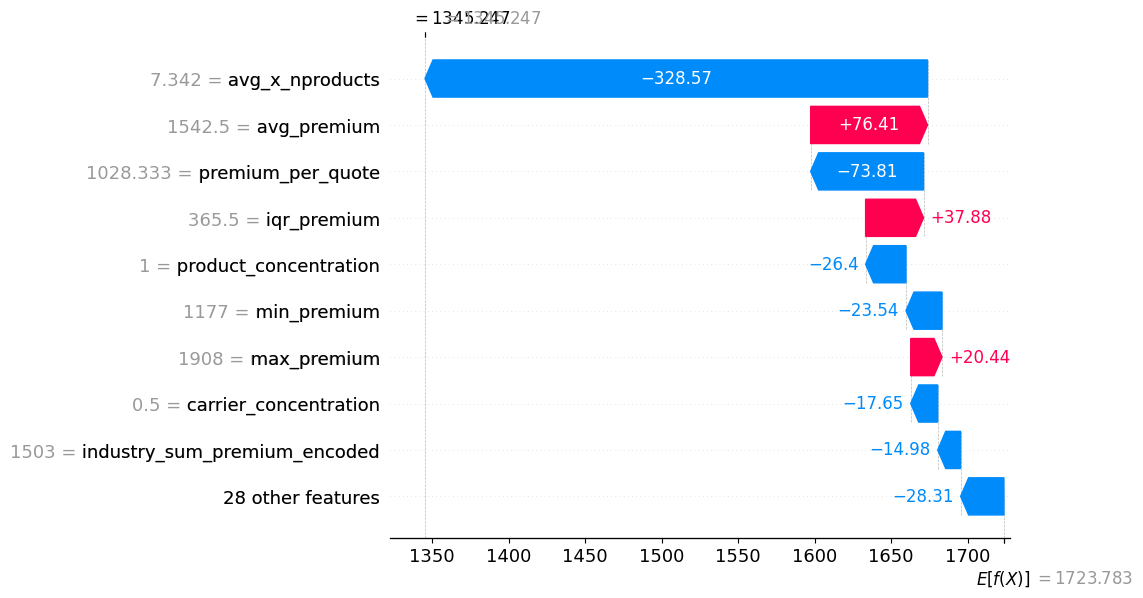

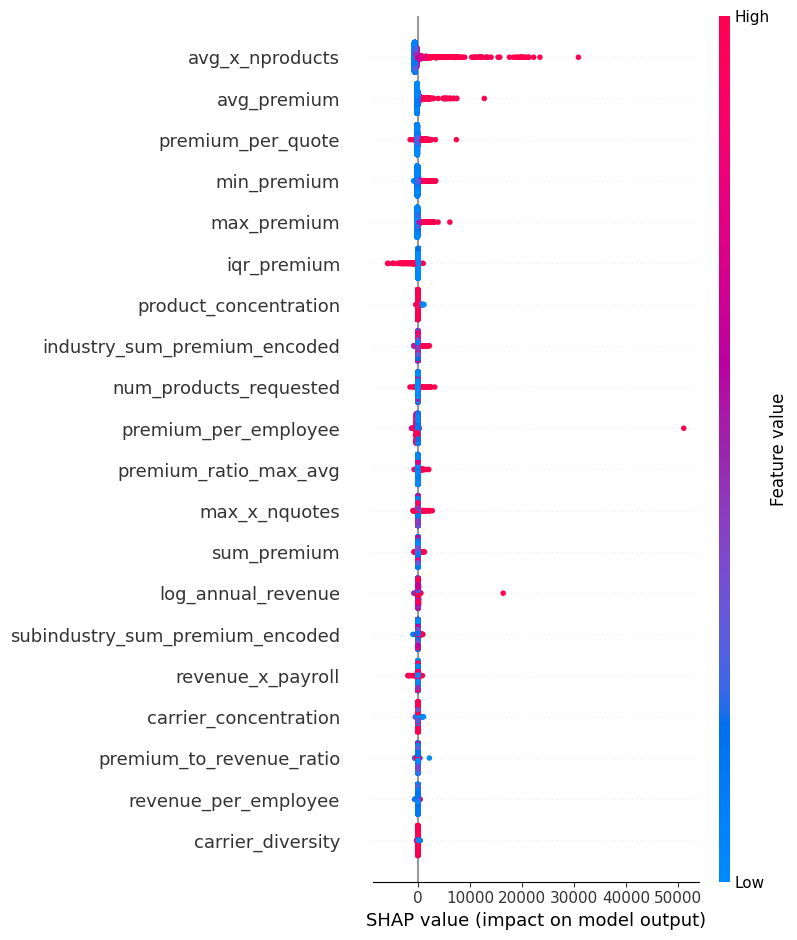

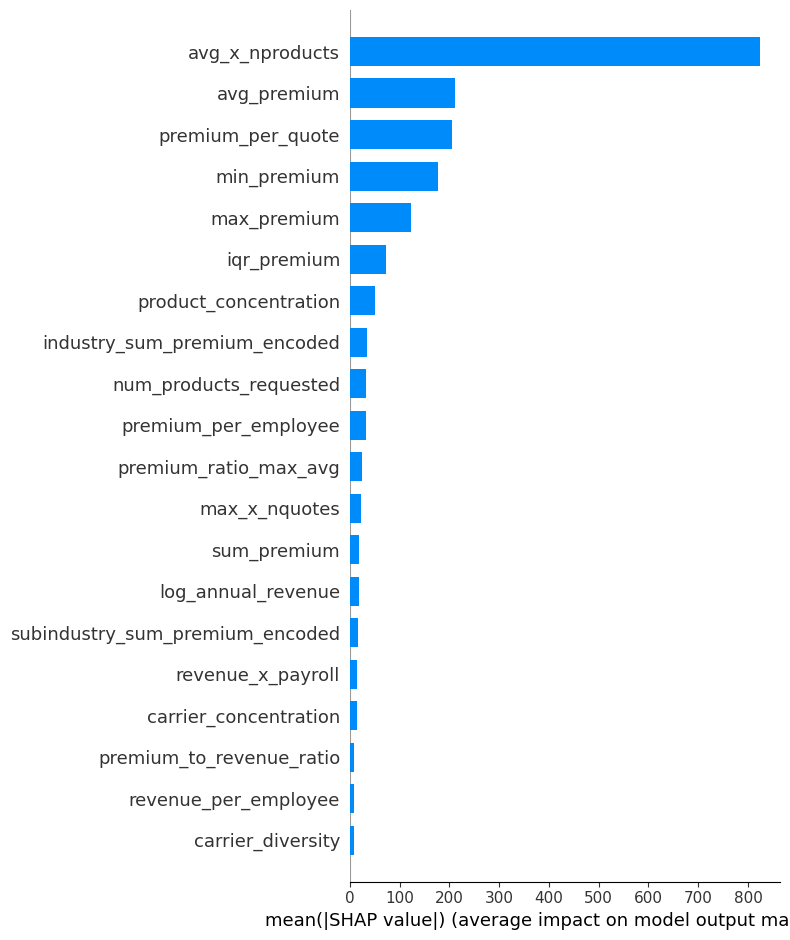

<Figure size 1400x800 with 0 Axes>

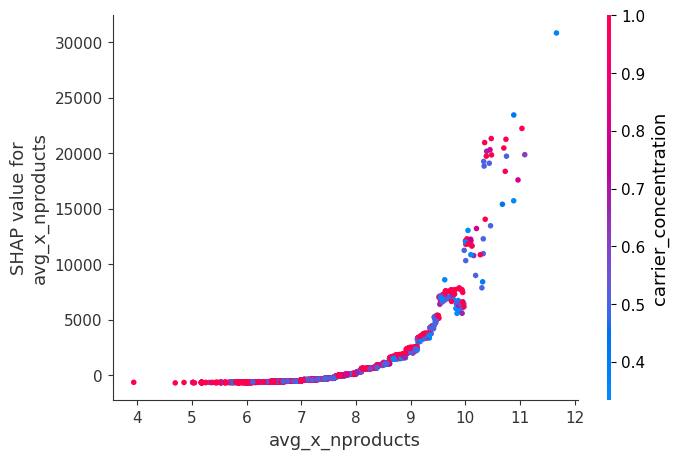

/tmp/ipykernel_111844/3005843687.py:42: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


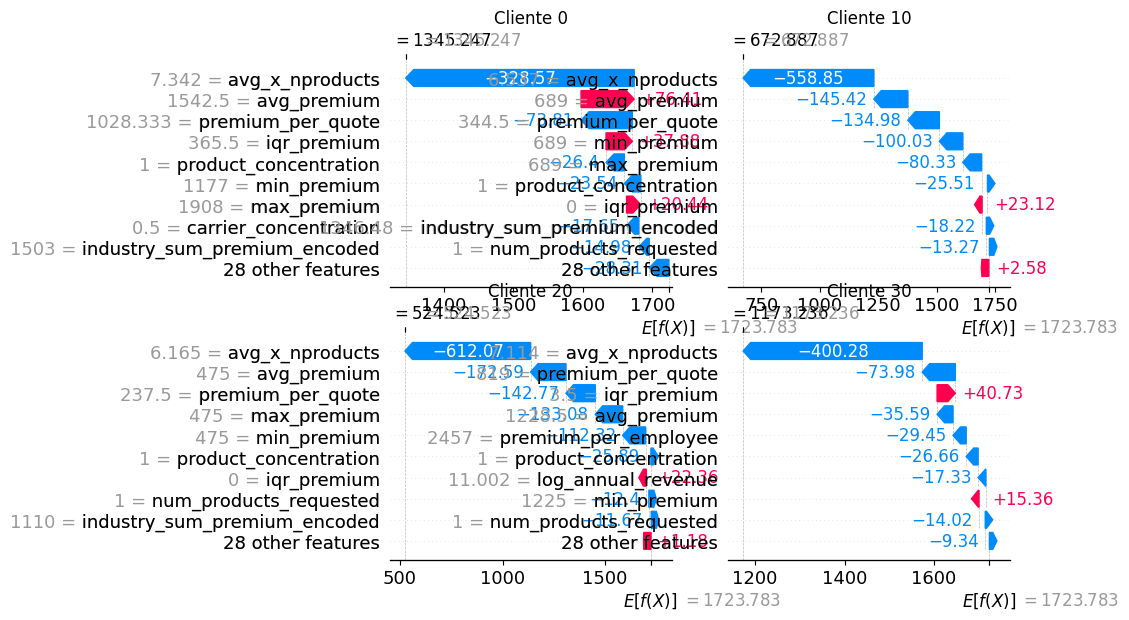

In [66]:
import shap
import matplotlib.pyplot as plt

# Tu código base
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_ordered)

print("Predicción base (promedio):", explainer.expected_value)
print("Predicción real:", model.predict(X_ordered.iloc[[0]])[0])

# ===== PLOTS CORREGIDOS =====

# 1. Waterfall plot - VERSIÓN CORRECTA
shap_explanation = explainer(X_ordered)  # Crear objeto Explanation
shap.plots.waterfall(shap_explanation[0])  # Plot para el primer caso
plt.show()

# 2. Force plot - Funciona igual
shap.force_plot(explainer.expected_value, shap_values[0], X_ordered.iloc[0])

# 3. Summary plot - Funciona igual
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_ordered, plot_type="dot")
plt.show()

# 4. Bar plot - Funciona igual  
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_ordered, plot_type="bar")
plt.show()

plt.figure(figsize=(14, 8))
# 5. Dependence plot - Funciona igual
shap.dependence_plot('avg_x_nproducts', shap_values, X_ordered)
plt.show()

# 6. Múltiples casos - VERSIÓN CORRECTA
fig, axes = plt.subplots(2, 2, figsize=(24, 16))
for i in range(4):
    plt.subplot(2, 2, i+1)
    shap.plots.waterfall(shap_explanation[i*10], show=False)  # Casos 0, 10, 20, 30
    plt.title(f"Cliente {i*10}")
plt.tight_layout()
plt.show()